In [ ]:
# Base
import os
import math
import itertools
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Prétraitement
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning - LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# ARIMA
from pmdarima import auto_arima as pm

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics



# Séries temporelles statistiques
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# NLP / Sentiment
#from textblob import TextBlob

# Scraping Reddit
#from psaw import PushshiftAPI

# Utilitaire
#from tqdm.auto import tqdm
#from scipy.stats import kendalltau


In [10]:
%pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ----------------- ---------------------- 1.3/3.0 MB 9.6 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 8.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
  Using cached cffi-1.17.1-cp311-cp311-win_amd64.whl.metadata (1.6 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -----------------------------------

# Loading and Preparing Data

In [122]:
import yfinance as yf

# Gold price (GC=F), SP500 (^GSPC)
gold = yf.download("GC=F", start="2016-01-01", end="2025-05-23")
sp500 = yf.download("^GSPC", start="2016-01-01", end="2025-05-23")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [98]:
print(gold.head())


Price             Close         High          Low         Open Volume
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F
Date                                                                 
2016-01-04  1075.099976  1082.500000  1063.199951  1063.400024    143
2016-01-05  1078.400024  1081.500000  1075.300049  1075.599976     82
2016-01-06  1091.900024  1093.699951  1081.599976  1081.599976     52
2016-01-07  1107.699951  1109.400024  1091.599976  1091.599976    122
2016-01-08  1097.800049  1111.099976  1093.000000  1111.099976     98


In [99]:
print(sp500.head())

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2016-01-04  2012.660034  2038.199951  1989.680054  2038.199951  4304880000
2016-01-05  2016.709961  2021.939941  2004.170044  2013.780029  3706620000
2016-01-06  1990.260010  2011.709961  1979.050049  2011.709961  4336660000
2016-01-07  1943.089966  1985.319946  1938.829956  1985.319946  5076590000
2016-01-08  1922.030029  1960.400024  1918.459961  1945.969971  4664940000


In [100]:
btc = yf.download("BTC-USD", start="2016-01-01", end="2025-05-23")

# Display the first 5 rows
print(btc.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2016-01-01  434.334015  436.246002  427.515015  430.721008  36278900
2016-01-02  433.437988  436.062012  431.869995  434.622009  30096600
2016-01-03  430.010986  433.743011  424.705994  433.578003  39633800
2016-01-04  433.091003  434.516998  429.084015  430.061005  38477500
2016-01-05  431.959991  434.182007  429.675995  433.069000  34522600


In [101]:
from fredapi import Fred
fred = Fred(api_key='ee69758895f63b2609f44977c352bfd1')

interest = fred.get_series('FEDFUNDS')
inflation = fred.get_series('CPIAUCSL')

In [102]:
# Convertir les Series en DataFrames
interest_df = interest.to_frame(name="interest_rate")
interest_df.index.name = "date"
interest_df = interest_df.reset_index()

inflation_df = inflation.to_frame(name="inflation_us")
inflation_df.index.name = "date"
inflation_df = inflation_df.reset_index()

In [103]:
# Filtrage des dates
interest_df = interest_df[(interest_df["date"] >= "2016-01-01") & (interest_df["date"] <= "2025-05-23")]
inflation_df = inflation_df[(inflation_df["date"] >= "2016-01-01") & (inflation_df["date"] <= "2025-05-23")]


In [104]:
interest_df.head(150)

,date,interest_rate
738,2016-01-01,0.34
739,2016-02-01,0.38
740,2016-03-01,0.36
741,2016-04-01,0.37
742,2016-05-01,0.37
...,...,...
845,2024-12-01,4.48
846,2025-01-01,4.33
847,2025-02-01,4.33
848,2025-03-01,4.33


In [105]:
inflation_df.head(112)

,date,inflation_us
828,2016-01-01,237.652
829,2016-02-01,237.336
830,2016-03-01,238.080
831,2016-04-01,238.992
832,2016-05-01,239.557
...,...,...
935,2024-12-01,317.603
936,2025-01-01,319.086
937,2025-02-01,319.775
938,2025-03-01,319.615


In [106]:
'''

import requests


API_KEY = '3f4a2990-3918-42a8-a1c4-86d6b674c9c2'

url = "https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical"

headers = {
    "Accepts": "application/json",
    "X-CMC_PRO_API_KEY": API_KEY,
}

params = {
    "time_period": "daily",
    "limit": 500
}

response = requests.get(url, headers=headers, params=params)


print("Status Code:", response.status_code)
print("JSON Response:")
print(response.json())

'''


'\n\nimport requests\n\n\nAPI_KEY = \'3f4a2990-3918-42a8-a1c4-86d6b674c9c2\'\n\nurl = "https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical"\n\nheaders = {\n    "Accepts": "application/json",\n    "X-CMC_PRO_API_KEY": API_KEY,\n}\n\nparams = {\n    "time_period": "daily",\n    "limit": 500\n}\n\nresponse = requests.get(url, headers=headers, params=params)\n\n\nprint("Status Code:", response.status_code)\nprint("JSON Response:")\nprint(response.json())\n\n'

In [107]:
# Load the full CSV without renaming columns
csv_filename = 'fear_greed_index.csv'
FGI_df = pd.read_csv(csv_filename)

FGI_df.head(100)


,timestamp,fear_greed_score
0,2018-02-01,30
1,2018-02-02,15
2,2018-02-03,40
3,2018-02-04,24
4,2018-02-05,11
...,...,...
95,2018-05-10,63
96,2018-05-11,41
97,2018-05-12,44
98,2018-05-13,40


In [108]:
FGI_df = FGI_df.rename(columns={"timestamp": "date"})
FGI_df

,date,fear_greed_score
0,2018-02-01,30
1,2018-02-02,15
2,2018-02-03,40
3,2018-02-04,24
4,2018-02-05,11
...,...,...
2655,2025-05-14,73
2656,2025-05-15,70
2657,2025-05-16,71
2658,2025-05-17,74


In [123]:
# Reset the index so 'Date' becomes a column
gold = gold.reset_index()

# Flatten the MultiIndex columns
gold.columns = gold.columns.get_level_values(-0)

# Rename columns with prefix "gold"
gold = gold.rename(columns={
    "Date": "date",
    "Close": "gold_close",
    "Open": "gold_open",
    "High": "gold_high",
    "Low": "gold_low",
    "Volume": "gold_volume"
})

gold.columns.name = None

In [124]:
gold

,date,gold_close,gold_high,gold_low,gold_open,gold_volume
0,2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
1,2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2,2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
3,2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
4,2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98
...,...,...,...,...,...,...
2354,2025-05-16,3182.000000,3228.100098,3173.899902,3227.699951,199
2355,2025-05-19,3228.899902,3241.000000,3228.300049,3234.399902,266
2356,2025-05-20,3280.300049,3293.199951,3207.500000,3219.000000,356
2357,2025-05-21,3309.300049,3317.500000,3290.199951,3293.399902,979


In [126]:

sp500 = sp500.reset_index()


sp500.columns = sp500.columns.get_level_values(0)

sp500 = sp500.rename(columns={
    "Date": "date",
    "Close": "sp500_close",
    "Open": "sp500_open",
    "High": "sp500_high",
    "Low": "sp500_low",
    "Volume": "sp500_volume"
})



In [129]:
sp500.columns.name = None
sp500

,date,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume
0,2016-01-04,2012.660034,2038.199951,1989.680054,2038.199951,4304880000
1,2016-01-05,2016.709961,2021.939941,2004.170044,2013.780029,3706620000
2,2016-01-06,1990.260010,2011.709961,1979.050049,2011.709961,4336660000
3,2016-01-07,1943.089966,1985.319946,1938.829956,1985.319946,5076590000
4,2016-01-08,1922.030029,1960.400024,1918.459961,1945.969971,4664940000
...,...,...,...,...,...,...
2356,2025-05-16,5958.379883,5958.620117,5907.359863,5929.089844,4850850000
2357,2025-05-19,5963.600098,5968.609863,5895.689941,5902.879883,4144010000
2358,2025-05-20,5940.459961,5953.060059,5909.259766,5944.660156,4416850000
2359,2025-05-21,5844.609863,5938.370117,5830.910156,5910.180176,5254250000


In [116]:

btc = btc.reset_index()
btc.columns = btc.columns.get_level_values(0)
btc = btc.rename(columns={
    "Date": "date",
    "Close": "btc_close",
    "Open": "btc_open",
    "High": "btc_high",
    "Low": "btc_low",
    "Volume": "btc_volume"
})



In [130]:
btc.columns.name = None
btc

,date,btc_close,btc_high,btc_low,btc_open,btc_volume
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600
...,...,...,...,...,...,...
3425,2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058
3426,2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647
3427,2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122
3428,2025-05-21,109678.078125,110724.460938,106127.234375,106791.312500,78086364051


In [134]:
# Merge everything
merged = btc.merge(sp500[["date", "sp500_close"]], on="date", how="left")
merged = merged.merge(gold[["date", "gold_close"]], on="date", how="left")

In [135]:
print(merged)

           date      btc_close       btc_high        btc_low       btc_open  \
0    2016-01-01     434.334015     436.246002     427.515015     430.721008   
1    2016-01-02     433.437988     436.062012     431.869995     434.622009   
2    2016-01-03     430.010986     433.743011     424.705994     433.578003   
3    2016-01-04     433.091003     434.516998     429.084015     430.061005   
4    2016-01-05     431.959991     434.182007     429.675995     433.069000   
...         ...            ...            ...            ...            ...   
3425 2025-05-18  106446.007812  106597.171875  103142.601562  103186.953125   
3426 2025-05-19  105606.179688  107068.718750  102112.687500  106430.531250   
3427 2025-05-20  106791.085938  107307.117188  104206.515625  105605.406250   
3428 2025-05-21  109678.078125  110724.460938  106127.234375  106791.312500   
3429 2025-05-22  111673.281250  111970.171875  109285.070312  109673.492188   

       btc_volume  sp500_close   gold_close  
0    

In [137]:
# Convert FGI_df['date'] to datetime
FGI_df['date'] = pd.to_datetime(FGI_df['date'])

# Optional but safe: convert merged['date'] as well
merged['date'] = pd.to_datetime(merged['date'])

In [138]:
merged = merged.merge(interest_df, on="date", how="left")
merged = merged.merge(inflation_df, on="date", how="left")
merged = merged.merge(FGI_df, on="date", how="left")

In [139]:
merged

,date,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate_x,inflation_us_x,interest_rate_y,inflation_us_y,fear_greed_score
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,0.34,237.652,NaN
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3425,2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,NaN,NaN,74.0
3426,2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN,NaN,NaN
3427,2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN,NaN,NaN
3428,2025-05-21,109678.078125,110724.460938,106127.234375,106791.312500,78086364051,5844.609863,3309.300049,NaN,NaN,NaN,NaN,NaN


In [140]:
# Drop duplicates if identical
merged = merged.drop(columns=["interest_rate_y", "inflation_us_y"])

# Rename the remaining ones
merged = merged.rename(columns={
    "interest_rate_x": "interest_rate",
    "inflation_us_x": "inflation_us"
})


In [141]:
merged

,date,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
0,2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,NaN
1,2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN
4,2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3425,2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,74.0
3426,2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN
3427,2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN
3428,2025-05-21,109678.078125,110724.460938,106127.234375,106791.312500,78086364051,5844.609863,3309.300049,NaN,NaN,NaN


In [142]:
#observe the different feature type present in the data

print("=============================================")
print("Data types of the columns in the data frame:",merged.dtypes)
print("=============================================")
print("Shape of the data frame:", merged.shape)
print("=============================================")
print("Information about the data frame:", merged.info())

Data types of the columns in the data frame: date                datetime64[ns]
btc_close                  float64
btc_high                   float64
btc_low                    float64
btc_open                   float64
btc_volume                   int64
sp500_close                float64
gold_close                 float64
interest_rate              float64
inflation_us               float64
fear_greed_score           float64
dtype: object
Shape of the data frame: (3430, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              3430 non-null   datetime64[ns]
 1   btc_close         3430 non-null   float64       
 2   btc_high          3430 non-null   float64       
 3   btc_low           3430 non-null   float64       
 4   btc_open          3430 non-null   float64       
 5   btc_volume        3430 non-nul

In [272]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp']).dt.tz_localize(None).dt.date

In [143]:
merged.set_index('date', inplace=True)
merged

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
date,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,NaN
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,74.0
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN


In [144]:
assert  merged.isnull().values.any(), "Data contains NaNs"

In [145]:
nan_rows_fetched_data = merged[merged.isnull().any(axis=1)]
nan_rows_fetched_data

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
date,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,NaN,NaN,0.34,237.652,NaN
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,NaN,NaN,NaN
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,NaN,NaN,NaN,NaN,74.0
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,NaN,NaN,NaN
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,NaN,NaN,NaN


In [147]:
merged = merged.sort_values("date")

In [148]:
# Interpolation linéaire sur les colonnes numériques
merged_interpolated = merged.interpolate(method='linear', limit_direction='both')

In [149]:
print("Valeurs manquantes après interpolation :")
print(merged_interpolated.isnull().sum())

Valeurs manquantes après interpolation :
btc_close           0
btc_high            0
btc_low             0
btc_open            0
btc_volume          0
sp500_close         0
gold_close          0
interest_rate       0
inflation_us        0
fear_greed_score    0
dtype: int64


In [153]:
df = merged_interpolated
df

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score
date,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,2012.660034,1075.099976,0.340000,237.652000,30.0
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,2012.660034,1075.099976,0.341290,237.641806,30.0
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,2012.660034,1075.099976,0.342581,237.631613,30.0
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,0.343871,237.621419,30.0
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,0.345161,237.611226,30.0
...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.321000,74.0
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.321000,74.0
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.321000,74.0


In [154]:
df['btc_close'] = pd.to_numeric(df['btc_close'], errors='coerce')
df.dropna(subset=['btc_close'], inplace=True)

In [155]:
# Create lag features
df['Prev_Close'] = df['btc_close'].shift(1)
df['3_Day_Mean'] = df['btc_close'].rolling(window=3).mean()
df['7_Day_Mean'] = df['btc_close'].rolling(window=7).mean()

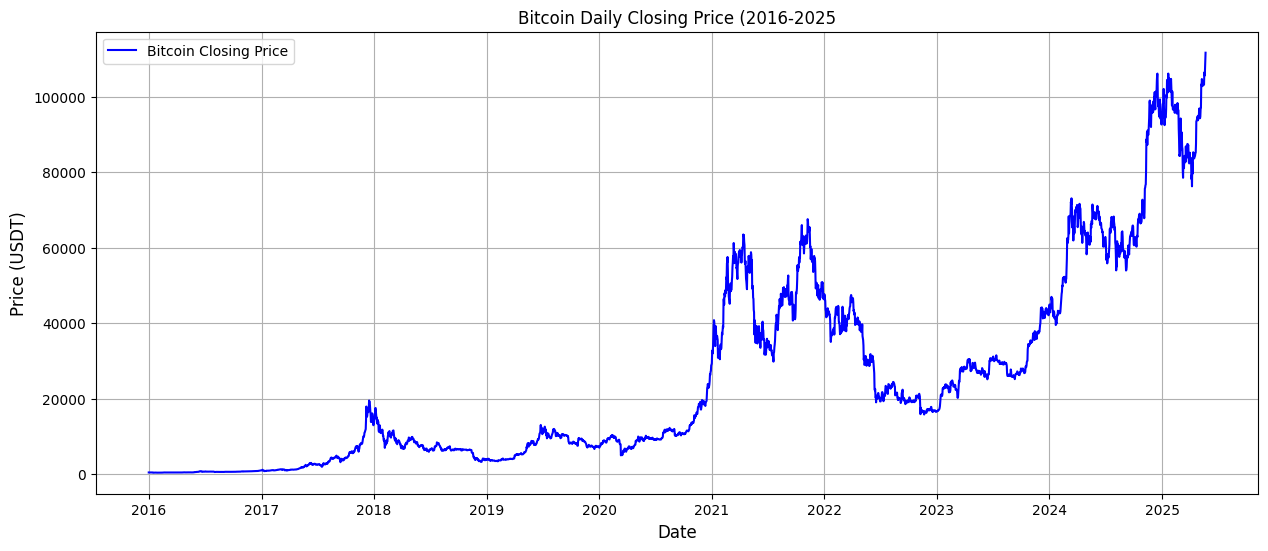

In [156]:
# Plot theb Bitcoin  prices graph
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['btc_close'], label='Bitcoin Closing Price', color='blue')
plt.title('Bitcoin Daily Closing Price (2016-2025')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USDT)', fontsize=12)
plt.legend()
plt.grid(True)


# Show the plt
plt.show()

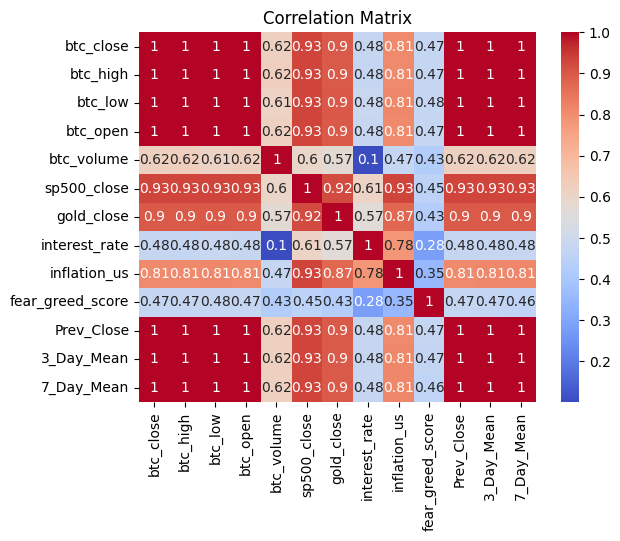

In [157]:

correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

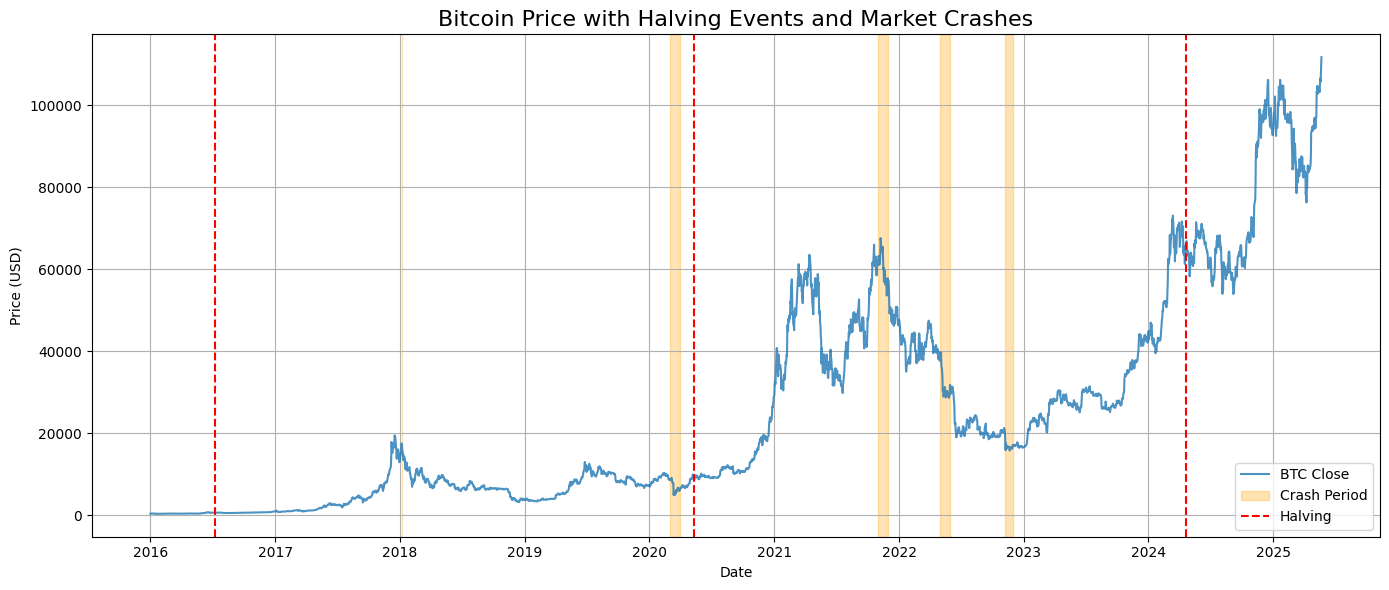

In [158]:

# Nettoyage de l'index (dates sans heures ni timezone)
df.index = pd.to_datetime(df.index).normalize()

# Définition des événements de halving et crash (sans timezone)
halving_dates = [
    pd.Timestamp("2016-07-09"),
    pd.Timestamp("2020-05-11"),
    pd.Timestamp("2024-04-20"),
]

crash_periods = [
    (pd.Timestamp("2018-01-06"), pd.Timestamp("2018-01-06")),
    (pd.Timestamp("2020-03-01"), pd.Timestamp("2020-03-31")),
    (pd.Timestamp("2021-11-01"), pd.Timestamp("2021-11-30")),
    (pd.Timestamp("2022-05-01"), pd.Timestamp("2022-05-31")),
    (pd.Timestamp("2022-11-08"), pd.Timestamp("2022-11-30")),
]

# Flags pour événements
df["halving_flag"] = df.index.isin(halving_dates)
df["crash_flag"] = False
for start, end in crash_periods:
    df.loc[start:end, "crash_flag"] = True

# Attribution de régimes
df["regime"] = "normal"
df.loc[df["halving_flag"], "regime"] = "halving"
df.loc[df["crash_flag"], "regime"] = "crash"

# Plot final
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["btc_close"], label="BTC Close", alpha=0.8)

# Crashes (zones orange)
for start, end in crash_periods:
    plt.axvspan(start, end, color="orange", alpha=0.3, label="Crash Period" if start == crash_periods[0][0] else "")

# Halvings (lignes rouges)
for date in halving_dates:
    plt.axvline(date, color="red", linestyle="--", linewidth=1.5, label="Halving" if date == halving_dates[0] else "")

plt.title("Bitcoin Price with Halving Events and Market Crashes", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [159]:
df

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score,Prev_Close,3_Day_Mean,7_Day_Mean,halving_flag,crash_flag,regime
date,,,,,,,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,2012.660034,1075.099976,0.340000,237.652000,30.0,NaN,NaN,NaN,False,False,normal
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,2012.660034,1075.099976,0.341290,237.641806,30.0,434.334015,NaN,NaN,False,False,normal
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,2012.660034,1075.099976,0.342581,237.631613,30.0,433.437988,432.594330,NaN,False,False,normal
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,0.343871,237.621419,30.0,430.010986,432.179993,NaN,False,False,normal
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,0.345161,237.611226,30.0,433.091003,431.687327,NaN,False,False,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.321000,74.0,103191.085938,104375.460938,103913.314732,False,False,normal
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.321000,74.0,106446.007812,105081.091146,104312.347098,False,False,normal
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.321000,74.0,105606.179688,106281.091146,104686.814732,False,False,normal


In [160]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df["btc_close"].dropna())

print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

if adf_result[1] < 0.05:
    print("Série stationnaire")
else:
    print("Série non stationnaire")

ADF Test Statistic: 0.35846961601803046
p-value: 0.9798736287973067
Critical Value (1%): -3.4322742112538958
Critical Value (5%): -2.8623902053483077
Critical Value (10%): -2.567222580397986
Série non stationnaire


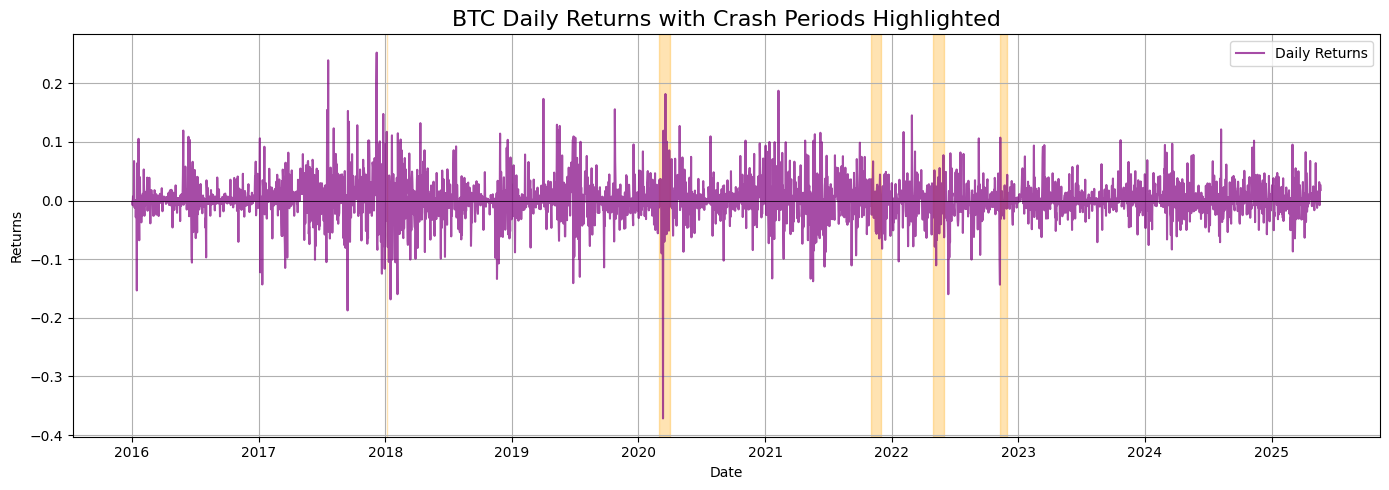

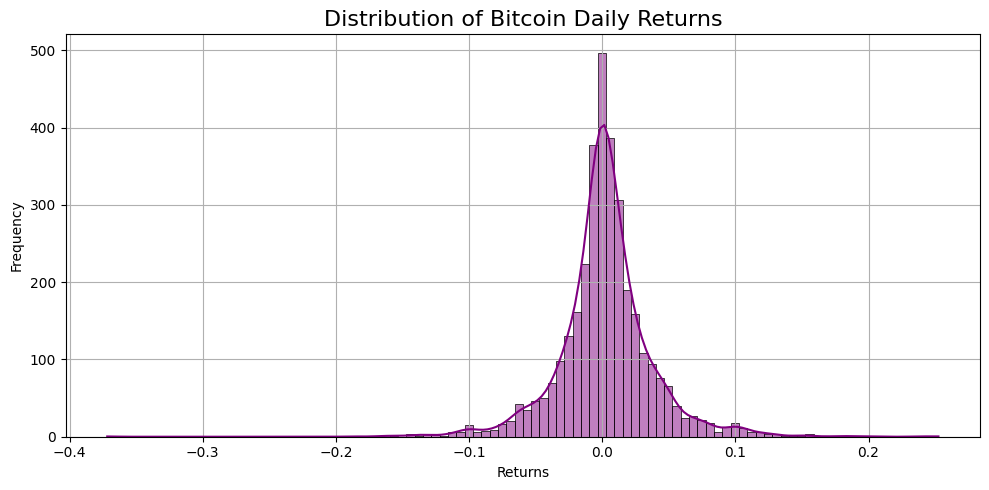

In [163]:
import seaborn as sns
# Returns volatility
df["returns"] = df["btc_close"].pct_change()

plt.figure(figsize=(14, 5))
plt.plot(df.index, df["returns"], color="purple", alpha=0.7, label="Daily Returns")
plt.axhline(0, color="black", linewidth=0.5)

for start, end in crash_periods:
    plt.axvspan(start, end, color="orange", alpha=0.3)

plt.title("BTC Daily Returns with Crash Periods Highlighted", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["returns"].dropna(), kde=True, bins=100, color="purple")
plt.title("Distribution of Bitcoin Daily Returns", fontsize=16)
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

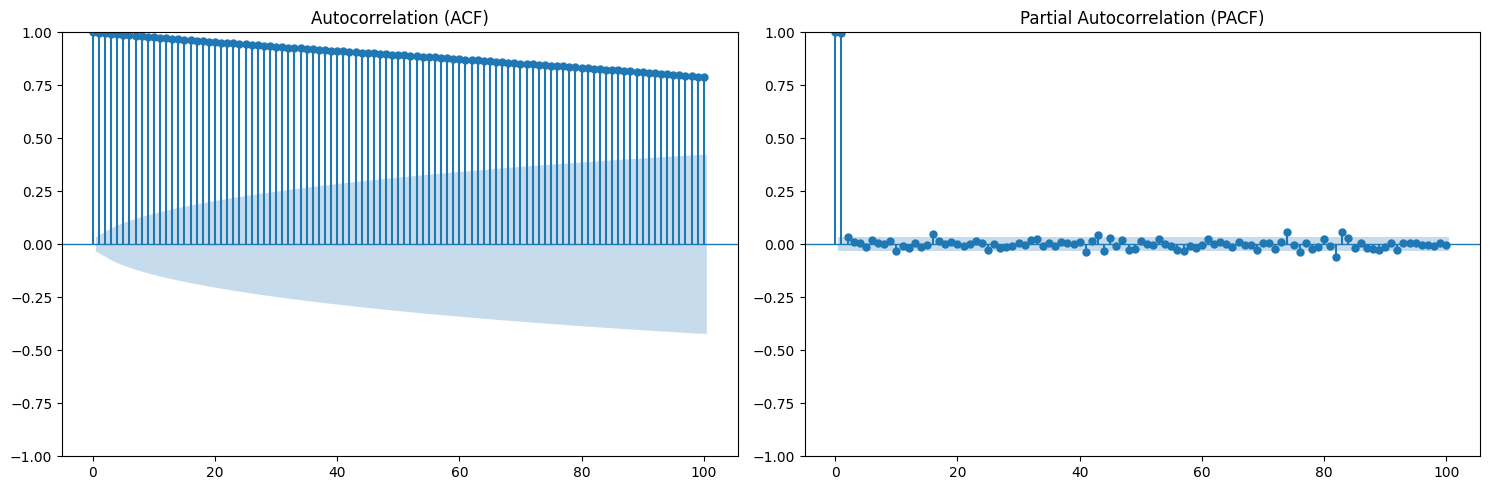

In [ ]:
# Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df["btc_close"].dropna(), ax=axes[0], lags=100, linewidth=1)
axes[0].set_title("Autocorrelation (ACF)")

plot_pacf(df["btc_close"].dropna(), ax=axes[1], lags=100, method="ywm", linewidth=1)
axes[1].set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

In [166]:
# How BTC moves around halving/crash events.
print(df.groupby("regime")["btc_close"].agg(["mean","std","count"]))

                 mean           std  count
regime                                    
crash    29442.007455  20818.013623    116
halving  24749.065776  35079.504594      3
normal   25141.280230  26242.796861   3311


# Data Preparation for Models

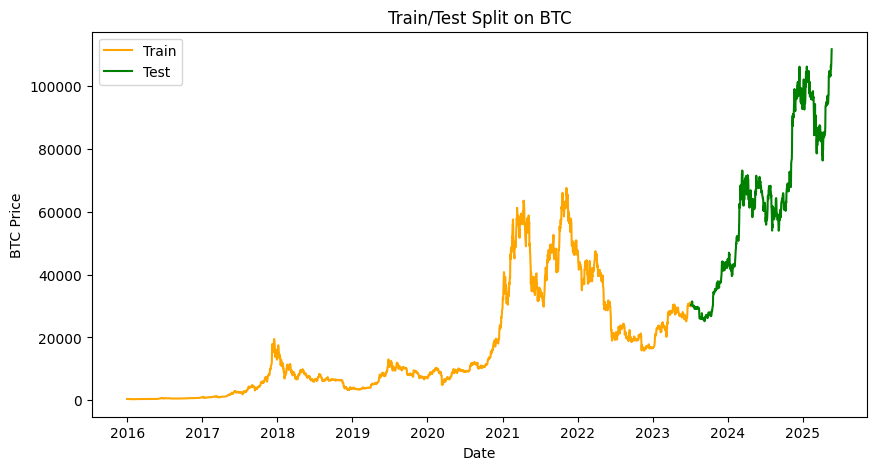

In [167]:
split_size = int(0.8 * len(df))
X_train = df.index[:split_size]
y_train = df['btc_close'][:split_size]

X_test = df.index[split_size:]
y_test = df['btc_close'][split_size:]


plt.figure(figsize=(10, 5))
plt.plot(X_train, y_train, label='Train', color='orange')
plt.plot(X_test, y_test, label='Test', color='green')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Train/Test Split on BTC")
plt.legend()
plt.show()


In [168]:
y_train.head(1)

date
2016-01-01    434.334015
Freq: D, Name: btc_close, dtype: float64

In [169]:
y_test.head(1)

date
2023-07-07    30342.265625
Freq: D, Name: btc_close, dtype: float64

# Auto Arima

In [ ]:
param_grid = {
    "trend":"t",
    "m": 7,  # Seasonal periodicity (e.g., 12 for monthly data)
    "stepwise":
        True,
      # Whether to use stepwise search for model selection
    "error_action": "ignore",  # Action on error ('warn', 'raise', 'ignore')
    "scoring": "mse",  # Scoring metric ('mse' for mean squared error)
    "start_p": 1,  # Start for auto ARIMA
    "d": None,  # Differencing parameter (None for automatic)
    "start_q": 1,  # Start for auto ARIMA
    "max_p":5,  # Maximum AR order
    "max_d": 2,  # Maximum differencing
    "max_q": 5,  # Maximum MA order
    "max_order": 10,  # Maximum total order
    "maxiter": 50,  # Maximum number of iterations
    "suppress_warnings": True,  # Suppress warnings
    "information_criterion": "aic",  # Information criterion for model selection
    "method": "lbfgs", # methode de hyperparameter tuning
    "trend_offset": 1,  # Offset for trend
    "solver": "lbfgs",  # Solver for optimization
    "start_params": None,  # Starting parameters
    "return_valid_fits": False,  # Whether to return valid fits
}



model = pm(y_train["close"], **param_grid, trace=True)
_tmp = model.summary().tables[0]
assert _tmp.data[1][0] == "Model:"
print (_tmp.data)
auto_ariba_bestfit_nm = _tmp.data[1][1] #le nom du modele
auto_ariba_bestfit_cls = model # la classe du modele
is_fitted = True

'param_grid = {\n    "trend":"t",\n    "m": 7,  # Seasonal periodicity (e.g., 12 for monthly data)\n    "stepwise":\n        True,\n      # Whether to use stepwise search for model selection\n    "error_action": "ignore",  # Action on error (\'warn\', \'raise\', \'ignore\')\n    "scoring": "mse",  # Scoring metric (\'mse\' for mean squared error)\n    "start_p": 1,  # Start for auto ARIMA\n    "d": None,  # Differencing parameter (None for automatic)\n    "start_q": 1,  # Start for auto ARIMA\n    "max_p":5,  # Maximum AR order\n    "max_d": 2,  # Maximum differencing\n    "max_q": 5,  # Maximum MA order\n    "max_order": 10,  # Maximum total order\n    "maxiter": 50,  # Maximum number of iterations\n    "suppress_warnings": True,  # Suppress warnings\n    "information_criterion": "aic",  # Information criterion for model selection\n    "method": "lbfgs", # methode de hyperparameter tuning\n    "trend_offset": 1,  # Offset for trend\n    "solver": "lbfgs",  # Solver for optimization\n 

In [ ]:
f_horizon=len(y_test)
forecast, conf_int = model.predict(
    n_periods=f_horizon, return_conf_int=True
)
conf_int = pd.DataFrame(conf_int)
conf_int.columns = ["lower", "upper"]

forecast_df = pd.DataFrame({"ds": forecast.index, "yhat": forecast.values})

fcast = pd.concat([forecast_df, conf_int], axis=1)



In [ ]:
backtest, backtest_conf_int = model.predict_in_sample(
    return_conf_int=True
)
conf_int_backtest = pd.DataFrame(backtest_conf_int)
conf_int_backtest.columns = ["lower", "upper"]
backtest_df = pd.DataFrame({"ds": backtest.index, "yhat": backtest.values})
bktest = pd.concat([backtest_df, conf_int_backtest], axis=1)

In [ ]:
bktest

,ds,yhat,lower,upper
0,2023-02-11,0.435691,-3045.438743,3046.310126
1,2023-02-12,20323.236746,18001.626743,22644.846748
2,2023-02-13,21793.911873,19479.316458,24108.507287
3,2023-02-14,21776.492356,19461.896942,24091.087771
4,2023-02-15,22149.587760,19834.992347,24464.183172
...,...,...,...,...
465,2024-05-21,70825.552674,68541.024642,73110.080705
466,2024-05-22,70425.773688,68141.245656,72710.301719
467,2024-05-23,69732.676326,67448.148294,72017.204358
468,2024-05-24,68025.739021,65741.210989,70310.267052


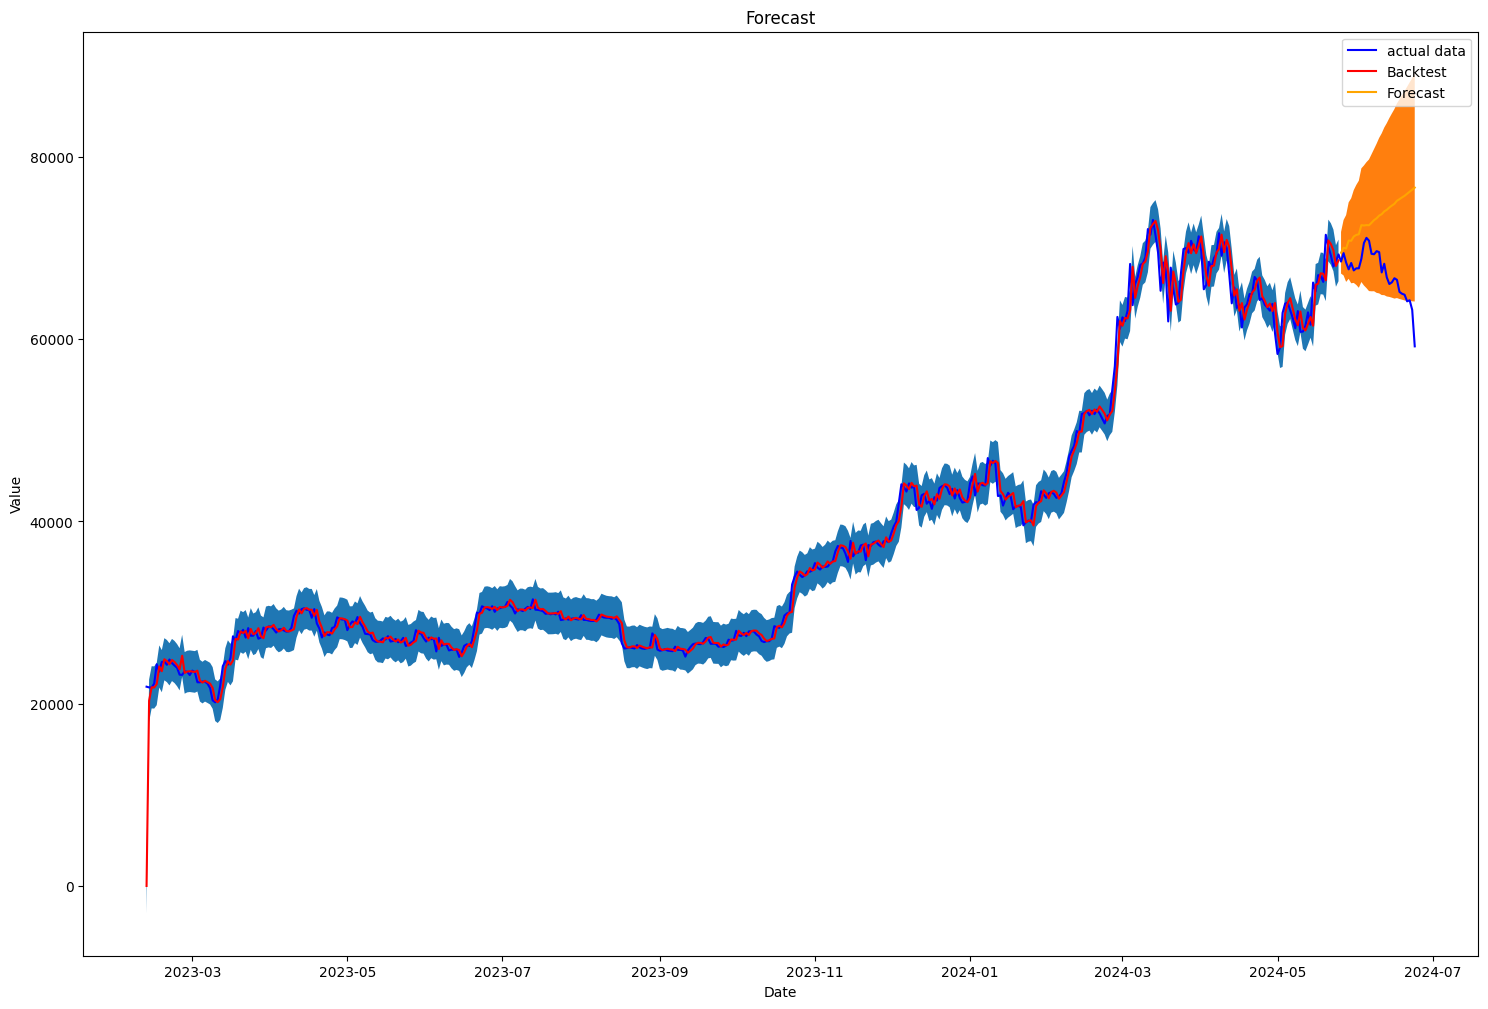

In [ ]:
def plot_forecast(forecast):
    plt.figure(figsize=(18, 12))
    plt.plot(
        df.index,
        df["btc_close"],
        label="actual data",
        color="blue",
    )

    plt.plot(
        bktest["ds"],
        bktest["yhat"],
        label="Backtest",
        color="red",
    )
    plt.fill_between(bktest["ds"], bktest["lower"],bktest["upper"])

    plt.plot(
        fcast["ds"],
        fcast["yhat"],
        label="Forecast",
        color="orange",
    )
    plt.fill_between(fcast["ds"], fcast["lower"],fcast["upper"])
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Forecast")
    plt.legend()
    plt.show()

plot_forecast(forecast)

# Prophet

In [ ]:
# Prepare the data for Prophet
# Ensure the 'date' column is in datetime format
df=df.copy().reset_index(drop=False)
df.rename(columns={'date': 'ds', 'btc_close': 'y'}, inplace=True)

rmses= list ()

param_grid={
    "daily_seasonality": [False, True],
    "weekly_seasonality":[False, True],
    "yearly_seasonality":[True, False],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], # to give higher value to prior trend
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0] # to control the flexibility of seasonality components
}

all_params= [
            dict(zip(param_grid.keys(), v))
            for v in itertools.product(*param_grid.values())
]

print(all_params)

# go through each combinations
for params in all_params:
    m= Prophet(**params)

    m= m.add_seasonality(name= 'monthly', period=15, fourier_order=5)
    m= m.add_seasonality(name= "quarterly", period= 30, fourier_order= 10)
    m.fit(df)


    df_cv= cross_validation(m, initial="30 days", period="30 days", horizon="30 days")

    df_p= performance_metrics(df_cv, rolling_window=1)

    rmses.append(df_p['rmse'].values[0])

# find the best parameters
best_params = all_params[np.argmin(rmses)]

print("\n The best parameters are:", best_params)

[{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': 

16:37:32 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/112 [00:00<?, ?it/s]16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:34 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/112 [00:00<00:50,  2.18it/s]16:37:34 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/112 [00:01<01:03,  1.74it/s]16:37:35 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
16:37:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:37:35 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/112 [00:01<00:59,  1.83


 The best parameters are: {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


In [ ]:
{'changepoint_range': 0.8, 'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}

In [ ]:
model = Prophet(**{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0})
model.fit(df)

# Create future dates for prediction
future = model.make_future_dataframe(periods=30)

# Make predictions
forecast = model.predict(future)


01:32:09 - cmdstanpy - INFO - Chain [1] start processing
01:32:10 - cmdstanpy - INFO - Chain [1] done processing


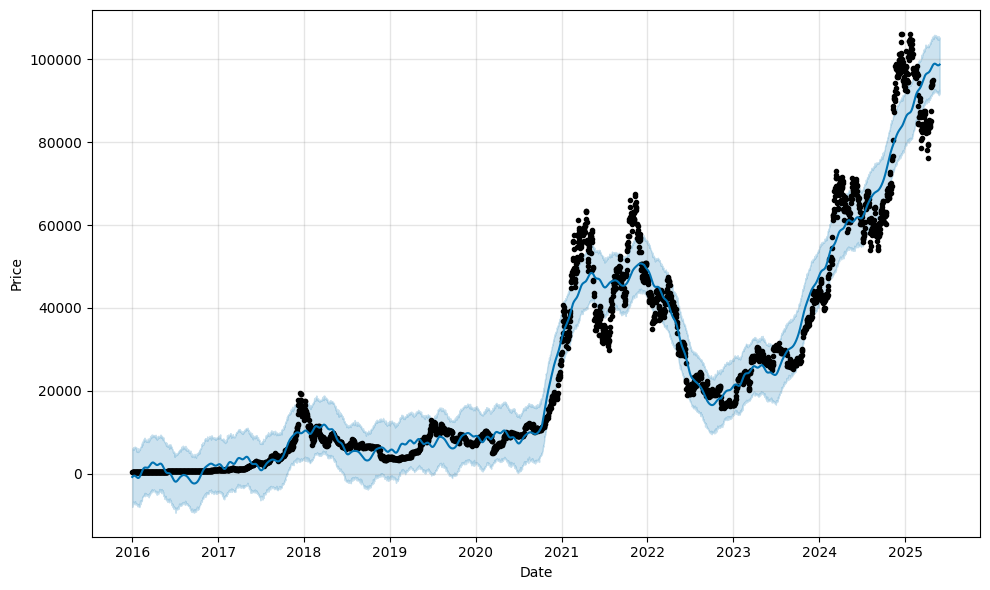

In [65]:
figure_1 = model.plot(forecast,
                    xlabel='Date',
                    ylabel='Price')


In [172]:
df

,btc_close,btc_high,btc_low,btc_open,btc_volume,sp500_close,gold_close,interest_rate,inflation_us,fear_greed_score,Prev_Close,3_Day_Mean,7_Day_Mean,halving_flag,crash_flag,regime,returns
date,,,,,,,,,,,,,,,,,
2016-01-01,434.334015,436.246002,427.515015,430.721008,36278900,2012.660034,1075.099976,0.340000,237.652000,30.0,NaN,NaN,NaN,False,False,normal,NaN
2016-01-02,433.437988,436.062012,431.869995,434.622009,30096600,2012.660034,1075.099976,0.341290,237.641806,30.0,434.334015,NaN,NaN,False,False,normal,-0.002063
2016-01-03,430.010986,433.743011,424.705994,433.578003,39633800,2012.660034,1075.099976,0.342581,237.631613,30.0,433.437988,432.594330,NaN,False,False,normal,-0.007907
2016-01-04,433.091003,434.516998,429.084015,430.061005,38477500,2012.660034,1075.099976,0.343871,237.621419,30.0,430.010986,432.179993,NaN,False,False,normal,0.007163
2016-01-05,431.959991,434.182007,429.675995,433.069000,34522600,2016.709961,1078.400024,0.345161,237.611226,30.0,433.091003,431.687327,NaN,False,False,normal,-0.002611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,106446.007812,106597.171875,103142.601562,103186.953125,49887082058,5961.860026,3213.266602,4.330000,320.321000,74.0,103191.085938,104375.460938,103913.314732,False,False,normal,0.031543
2025-05-19,105606.179688,107068.718750,102112.687500,106430.531250,61761126647,5963.600098,3228.899902,4.330000,320.321000,74.0,106446.007812,105081.091146,104312.347098,False,False,normal,-0.007890
2025-05-20,106791.085938,107307.117188,104206.515625,105605.406250,36515726122,5940.459961,3280.300049,4.330000,320.321000,74.0,105606.179688,106281.091146,104686.814732,False,False,normal,0.011220


# LSTM

In [ ]:
class LSTMTrainer:
    def __init__(self, df) -> None:
        self.target_data = df.copy().reset_index()
        self.target_data = df[["btc_close", "btc_volume", "sp500_close", "gold_close", 
                       "interest_rate", "inflation_us", "fear_greed_score",
                       "halving_flag", "crash_flag"]]
        self.model = None
        self.history = None
        self.scaler = None

    def preper_dataset(self, training_size, time_step=1):
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.target_data = self.scaler.fit_transform(self.target_data)

        train_len = int(len(self.target_data) * training_size)
        train_data = self.target_data[:train_len]
        test_data = self.target_data[train_len:]

        def _create_dataset(dataset, time_step=1):
            dataX, dataY = [], []
            for i in range(len(dataset) - time_step - 1):
                a = dataset[i:(i + time_step), :]  
                dataX.append(a)
                dataY.append(dataset[i + time_step, 0])  
            return np.array(dataX), np.array(dataY)

        X_train, y_train = _create_dataset(train_data, time_step)
        X_test, y_test = _create_dataset(test_data, time_step)

        print(f"X_train shape: {X_train.shape}")
        print(f"X_test shape: {X_test.shape}")

        return X_train, y_train, X_test, y_test

    def create_model(self, X_train):
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test):
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=32,
            verbose=1,
            callbacks=[early_stopping]
        )

        
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return self.history

    def inference_model(self, X_train, y_train, X_test, y_test):
        # Prédictions
        train_predict = self.model.predict(X_train)
        test_predict = self.model.predict(X_test)

        
        close_scaler = MinMaxScaler(feature_range=(0, 1))
        close_data = self.target_data[:, 0].reshape(-1, 1)
        close_scaler.fit(close_data)

       
        train_predict_rescaled = close_scaler.inverse_transform(train_predict).flatten()
        test_predict_rescaled = close_scaler.inverse_transform(test_predict).flatten()

        
        y_train_rescaled = close_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

        # Afficher les erreurs RMSE
        print("RMSE Train:", math.sqrt(mean_squared_error(y_train_rescaled, train_predict_rescaled)))
        print("RMSE Test :", math.sqrt(mean_squared_error(y_test_rescaled, test_predict_rescaled)))

        # Reconstruction des séries complètes pour affichage
        total_close = close_scaler.inverse_transform(close_data).flatten()

        look_back = 1
        trainPredictPlot = np.empty_like(total_close)
        trainPredictPlot[:] = np.nan
        trainPredictPlot[look_back:len(train_predict_rescaled) + look_back] = train_predict_rescaled

        testPredictPlot = np.empty_like(total_close)
        testPredictPlot[:] = np.nan
        testPredictPlot[len(train_predict_rescaled) + (look_back * 2) + 1:len(total_close) - 1] = test_predict_rescaled

        # Affichage 
        plt.figure(figsize=(12, 6))
        plt.plot(total_close, label='True Price')
        plt.plot(trainPredictPlot, label='Train Prediction')
        plt.plot(testPredictPlot, label='Test Prediction')
        plt.title("Bitcoin Price Prediction")
        plt.xlabel("Time step")
        plt.ylabel("BTC Price")
        plt.legend()
        plt.show()



In [198]:
trainer = LSTMTrainer(df = df)

In [199]:
#X_train,y_train, X_test, y_test = trainer.preper_dataset(training_size=0.7)
X_train, y_train, X_test, y_test = trainer.preper_dataset(training_size=0.7)

X_train shape: (2399, 1, 9)
X_test shape: (1027, 1, 9)


In [200]:
trainer.create_model(X_train)

c:\Users\Sabrine\Desktop\BTC_Forecasting\btc_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Sequential name=sequential_4, built=True>

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0212 - val_loss: 0.0156
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.7675e-04 - val_loss: 0.0062
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6454e-04 - val_loss: 0.0045
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7616e-04 - val_loss: 0.0032
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6446e-04 - val_loss: 0.0027
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3854e-04 - val_loss: 0.0030
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5906e-04 - val_loss: 0.0017
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1045e-04 - val_loss: 0.0024
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5256e-04 - val_loss: 0.0015
Epoch 12/100
75/75 ━━━━━━━━━━━━

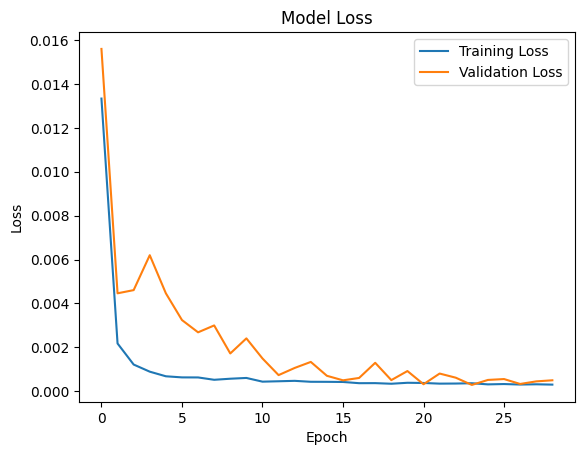

In [201]:
trainer.train_model(X_train,y_train, X_test, y_test)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE Train: 0.00963202571290819
RMSE Test : 0.017039156448263766


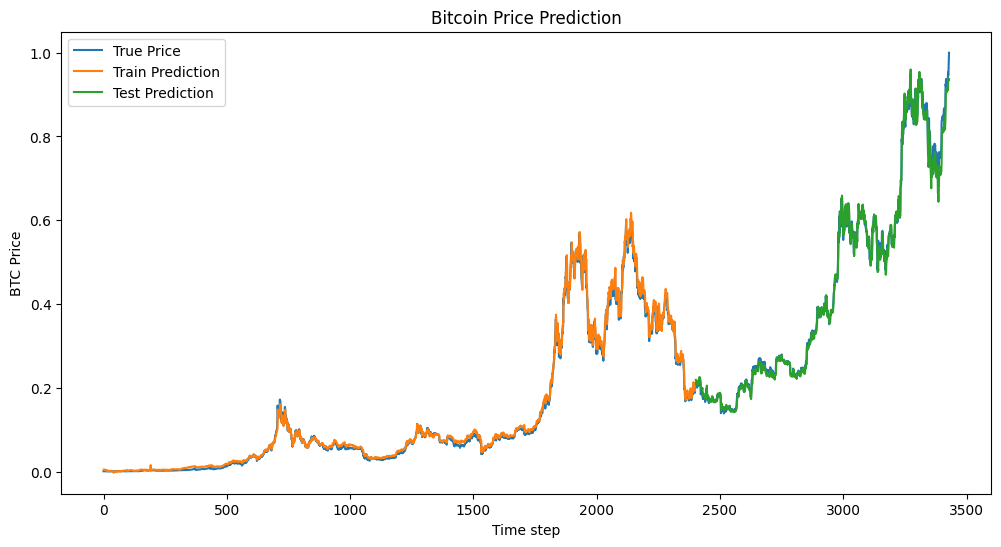

In [202]:
trainer.inference_model(X_train,y_train, X_test, y_test)
